In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc, f1_score

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse

import datetime
import json
import requests
import time
from collections import defaultdict
import pickle

from pymongo import MongoClient, InsertOne, DeleteOne, ReplaceOne

In [42]:
toxic = pd.read_csv('toxicity_data/train.csv') #there's also a test dataset but it doesn't have labels b/c kaggle.
#test.fillna(' ',inplace=True) - this line can clean up some issues in the test data if you do use it
print('Number of rows and columns in the train data set:',toxic.shape)

#unlabeled data
incel_df = pd.read_csv('new_IncelTears_posts.csv')
slate_df = pd.read_csv('new_slatestarcodex_posts.csv')

raw_toxic = toxic
small_toxic = toxic # this decreases time from 50 seconds to less
#small_toxic = toxic # this is just so I don't have to rename rest of cells

#turn multi-class into single class classifier
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = small_toxic[target_col]
y['sum'] = y.sum(axis=1).astype(bool).astype(int) 

# try undersampling

small_toxic['target']=y['sum']
neg_sample = small_toxic[small_toxic['target']==0].sample(2000)
pos_sample = small_toxic[small_toxic['target']==1].sample(2000)
all_df = pd.concat([neg_sample,pos_sample])

# ##Original code, doesn't do as well as undersampled code
# X_train, X_holdout, y_train, y_holdout = train_test_split(small_toxic.drop('target',axis=1), small_toxic['target'], test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# this is for undersampling
X_train, X_holdout, y_train, y_holdout = train_test_split(all_df.drop('target',axis=1), all_df['target'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Number of rows and columns in the train data set: (159571, 8)


In [43]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
tr_vect = vect_word.fit_transform(X_train['comment_text'])
ts_vect = vect_word.transform(X_test['comment_text'])

incel_vect = vect_word.transform(incel_df['title'])
slate_vect = vect_word.transform(slate_df['title'])

#took 50 seconds on 150k samples

In [44]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [45]:
tsne = TSNE(n_components=2, init='random', random_state=42)
test_2 = tsne.fit_transform(tr_vect.toarray()) #w/ 1k took very little time

In [48]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

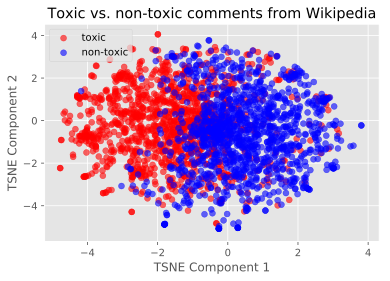

In [55]:
class_1 = y_train==1
class_0 = y_train==0

fig = plt.figure()
plt.scatter(test_2[class_1,0],test_2[class_1,1], c='red', alpha=.6, label='toxic')
plt.scatter(test_2[class_0,0],test_2[class_0,1], c='blue', alpha=.6, label='non-toxic')
plt.title('Toxic vs. non-toxic comments from Wikipedia')
plt.ylabel('TSNE Component 2')
plt.xlabel('TSNE Component 1')
plt.legend(loc='upper left');
# figure = a.get_figure()
# figure.savefig('images/class_imbalance.svg',  bbox_inches='tight')
fig.savefig('images/tsne.svg',  bbox_inches='tight')
